# Outline

In neuron test v02, the plan is to use a single low res slice, and register data from its corresponding high res slices.

For now I'm doing all the slices separately.

In v03 I transform neurons into the big space as well.

Next step in v04 will be to combine all the slices together with the atlas.


in version 07 we need to fix the flat neuron outputs

Note I have put the original from chris park here
/home/dtward/bmaproot/nafs/dtward/dong/dragonfly_tme07_neurons

and the latest
/home/dtward/bmaproot/nafs/dtward/dong/dragonfly_tme07_neurons/updated_coords

then we can deal with the new atlas.



in v08 we have the new atlas and have output to csv

we are working on fuzzy labels and double checking connectivity

In [1]:
# note that in tme08, neurons are somewhere else


In [2]:
import numpy as np
# %matplotlib notebook
%matplotlib widget

import matplotlib.pyplot as plt
from os.path import split,join,splitext,basename
from os import makedirs, listdir
from glob import glob
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.collections import PolyCollection, LineCollection
from os import walk
from skimage import measure

from sys import path
# path.append('/home/dtward/data/csh_data/emlddmm')
path.append('/home/abenneck')
from emlddmm import emlddmm
from os import makedirs
path.append('..')
import donglab_workflows as dw

path.append('panfs/dong')

In [3]:
# here we have a backup unpickler that ignores figures in case there are version issues
import pickle
import subprocess
from numpy.lib.format import read_magic, _check_version, _read_array_header
class ClassHack:
    '''
    This class provides methods that my unpickling requires, but
doesn't do anything
    '''
    def __init__(self,*args,**kwargs):
        pass
    def __call__(*args,**kwargs):
        pass
    def _remove_ax(self,*args,**kwargs):
        pass
    def _remove_legend(self,*args,**kwargs):
        pass
    def delaxes(self,*args,**kwargs):
        pass
    def _key_handler(self,*args,**kwargs):
        pass
    def pick(self,*args,**kwargs):
        pass
class Unpickler(pickle.Unpickler):
    '''
    An unpickler which can ignore old matplotlib figures stored in a dictionary
    '''
    def find_class(self, module, name):
        #print(module,name)
        if name == 'CallbackRegistry':
            #print('found callback registry')
            return ClassHack
        elif name == 'AxesStack':
            #print('found axes stack')
            return ClassHack
        elif name == '_picklable_subplot_class_constructor':
            #print('found subplot class constructor')
            return ClassHack
        elif module == 'matplotlib.figure' and name == 'Figure':
            return ClassHack    
        elif module =='matplotlib.backend_bases':
            return ClassHack
        else:
            #print('normal module name')
            return super().find_class(module,name)
def backup_unpickle(reg_file)        :
    output = subprocess.run(['unzip','-o',reg_file],capture_output=True)
    with open('out.npy','rb') as f:
        version = read_magic(f)
        _check_version(version)
        dtype = _read_array_header(f, version)[2]    
        out = Unpickler(f).load().item()
    return out

In [4]:
def load_swc(fname,skip=0):
    ''' load an swc file.
    
    Parameters
    ----------
    fname : str
        A string pointing to the file to load
    skip : int
        Number of lines to skip at the beginning. (default 0)
    
    Returns
    -------
    V : numpy array of float
        An array storing vertices
    E : numpy array of int
        An array storing edges.  they are ordered as parent -> this sample
    R : numpy array of float
        An arrow storing radii
    
    '''

    # Instead, a folder containing fname is passed
    # print(f'fname before: {fname}')
    # if '.swc' not in fname:
    #     for file in os.listdir(fname):
    #         if '.swc' in file:
    #             fname = os.path.join(fname,file)
    #             print(f'fname during: {fname}')
    #             break
    # print(f'fname after: {fname}')
        
    
    # load an swc
    # recall columns
    # data type, sample number, structure identifier, x,y,z,r,parent
    v = {}
    e = []
    r = {}
    with open(fname,'rt') as f:
        for i,line in enumerate(f):
            #print(line)
            if i < skip:
                continue
                
            #print(line)
            data = line.split()
            # may be comma separated
            if len(data)==1:
                data = line.split(',')
            sample_number = int(data[0])
            x = float(data[2])
            y = float(data[3])
            z = float(data[4])
            r_ = float(data[5])
            v[sample_number] = np.array([x,y,z])
            r[sample_number] = np.array(r_)

            par = int(data[-1])
            if par >= 0:
                #e.append([par,sample_number,])
                e.append([par-1,sample_number-1,]) # move to zero indexing
                pass
    # we want to put v into a numpy array
    maxkey = np.max([k for k in v])
    V = np.ones((maxkey,3))*np.nan
    for key in v:                
        V[key-1] = v[key] # zero indexing
    R = np.ones((maxkey,))*np.nan
    for key in r:
        R[key-1] = r[key] # zero indexing
    E = np.array(e)
    return V,E,R 

### Define Paths for Yang Images, Transform Outputs, & 10_to_30 Outputs

In [5]:
# Update the brain to be processed
# brain = 'TME07-1'
# brain = 'TME08-1'
# brain = 'TME09-1'
# brain = 'TME10-1'
# brain = 'TME10-3'
# brain = 'TME12-1'
# brain = 'TME20-1'
brain = 'Hpca5-2'
# brain = 'Sp9-3-2'
# brain = 'Trank1-2-3'
# brain = 'Zswim4-1'
# brain = 'MQC06-2'
# brain = 'MQC09-3'
# brain = 'MQC18-3'
# brain = 'MQC82-2'
# brain = 'hTME15-1'
# brain = 'hTME15-2'
# brain = 'hTME18-1'
# brain = 'hTME19-2'
# brain = '12m_MQC06-2'
# brain = '12m_MQC15-1'
# brain = '12m_MQC18-3'
# brain = '12m_MQC07-5'
# brain = '12m_MQC09-3'
# brain = '12m_MQC6-4'

# Defines location of (10x & 30x) data (Needed if raw data is in subdirectory)
orientation = 'W'
if brain in ['TME08-1', 'TME10-1', 'TME10-3', 'TME12-1', 'TME20-1', 'TME07-1', 'TME09-1']:
    brain_path = brain
elif brain in ['MQC06-2', 'MQC09-3', 'MQC18-3', 'MQC82-2']: # The original HD brains
    orientation = 'R'
    brain_path = f'Q140_MORF/{brain}'
elif '12m' in brain: # The new HD brains
    orientation = 'L'
    if '06-2' in brain or '15-1' in brain or '18-3' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3_{brain}'
    elif '09-3' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_{brain}'
    elif '07-5' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_{brain}'
        orientation = 'R'
    elif '6-4' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC6-4 (prev 6-3)'
        orientation = 'L'
    else:
        raise Exception('Invalid brain')
elif 'hTME' in brain:
    orientation = 'R'
    if 'hTME15-1' in brain or 'hTME19-2' in brain:
        brain_path = f'Q140_MORF_D1/Camk-MORF3-D1Tom_12m_{brain}'
    elif 'hTME15-2' in brain or 'hTME18-1' in brain:
        brain_path = f'Q140_MORF_D1/Camk-MORF3-D1Tom-Q140_12m_{brain}'
    else:
        raise Exception('Invalid brain')
else: # KO-Het_MORF
    orientation = 'L'
    if 'Hpca' in brain:
        brain_path = f'KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2'
    elif 'Sp9' in brain:
        brain_path = f'KO-Het_MORF/Sp9Het-Camk-MORF3-D1tom_Sp9-3-2'
    elif 'Trank' in brain:
        brain_path = f'KO-Het_MORF/Trank1KO-Camk-MORF3-D1tom_Trank1-2-3'
    elif 'Zswim' in brain:
        brain_path = f'KO-Het_MORF/Zswim6Het-Camk-MORF3-D1tom_Zswim4-1'
    else:
        raise Exception('Invalid brain')

# Path to directory containing (.swc) files for all neurons associated with this brain
if 'TME12-1' in brain:
    neuron_dir = f'/panfs/dong/3D_registration/Yang_MORF_DragonFly/{brain_path}_recontructions'   
elif 'TME07-1' in brain:
    neuron_dir = f'/nafs/dtward/dong/dragonfly_tme07_neurons/updated_coords'
else:
    neuron_dir = f'/panfs/dong/3D_registration/Yang_MORF_DragonFly/{brain_path}_reconstructions'

# Path to directory containing all microscopy images associated with this brain
if 'TME07-1' in brain:
    image_dir = '/nafs/dtward/dong/dragonfly_03_2022'
else:
    image_dir = f'/panfs/dong/3D_registration/Yang_MORF_DragonFly/{brain_path}_downsampled'

# Path to directory containing all 10x to 30x transforms (.npz files) associated with this brain
reg_dir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_10_to_30_outputs'

# File path for the 10x to atlas transform (.npz file) associated with this brain
transform_file = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_output_vis/transformation_outputs.npz'

### Load Atlas Images

In [6]:
# load atlas images
# atlas_names = [
#     '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk',
#     '/home/dtward/data/AllenInstitute/allen_vtk/average_template_50.vtk',
# ]

atlas_names = [
    '/nafs/dtward/allen_vtk/allen_vtk/ara_nissl_50.vtk',
    '/nafs/dtward/allen_vtk/allen_vtk/average_template_50.vtk',
]

# seg_name = '/home/dtward/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'
ontology_name = '/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'

# channel for 10 to 30 reg
channel_10_to_30 = 0

### Define output directory

In [7]:
output_dir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs'
makedirs(output_dir,exist_ok=True)

In [8]:
#image_low_files = glob(join(image_dir,'*10x*channel_1_down.npz'))
#image_low_files

In [9]:
# we need to walk through the dir to get the files
image_low_files = []
for dirpath, dirnames, filenames in walk(image_dir):
    if 'TME07-1' in brain:
        files = glob(join(dirpath,f'*10x*channel_{channel_10_to_30}*.npz'))
    elif brain in ['MQC06-2', 'MQC09-3', 'MQC82-3', '12m_MQC15-1', '12m_MQC09-3'] or 'hTME' in brain:
        files = glob(join(dirpath,f'*10X*ch_{channel_10_to_30}*.npz'))
    elif '12m' in brain:
        target_pattern_0 = f'*10X*_ch_{channel_10_to_30}*.npz'
        target_pattern_1 = f'*10x*_ch_{channel_10_to_30}*.npz'
        if len(glob(join(dirpath,target_pattern_0))) != 0:
            files = glob(join(dirpath,target_pattern_0))
        elif len(glob(join(dirpath,target_pattern_1))) != 0:
            files = glob(join(dirpath,target_pattern_1))       
    else:
        files = glob(join(dirpath,f'*10x*ch_{channel_10_to_30}*.npz'))
    image_low_files.extend(files)
image_low_files.sort()

In [10]:
image_low_files

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_01_2023-02-24_11.52.21_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_02_2023-02-24_12.06.13_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_03_2023-02-24_12.21.08_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_04_2023-02-24_13.42.12_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MOR

In [11]:
# transformations
dataat = np.load(transform_file,allow_pickle=True)
print([k for k in dataat])

['xv', 'v', 'xvJ', 'vJ', 'A', 'AJ', 'TJ', 'dtype']


In [12]:
# load segmentation
xS,S,title,names = emlddmm.read_data(seg_name, normalize=False)

# Will zero-out atlas image for the hemisphere we are NOT aligning
if orientation == 'L':
    S[:,:,int(np.shape(S)[2]/2 + 1):,:] = np.zeros([np.shape(S)[0],np.shape(S)[1],int(np.shape(S)[2]/2 - 1),np.shape(S)[3]])
elif orientation == 'R':
    S[:,:,:int(np.shape(S)[2]/2),:] = np.zeros([np.shape(S)[0],np.shape(S)[1],int(np.shape(S)[2]/2),np.shape(S)[3]])
else:
    print(f'{brain} is a whole brain')

dS = np.array([x[1]-x[0] for x in xS])

In [13]:
# downsample segmentation
xSd,Sd = emlddmm.downsample_image_domain(xS,(S>0)*1.0,[5,5,5])
dSd = [x[1] - x[0] for x in xSd]

In [14]:
# create isosurface of segmentation
verts,faces,normals,values = measure.marching_cubes((Sd[0]>0)*1.0,level=0.5)
verts *= dSd # for 100 micron
verts += np.array((xSd[0][0],xSd[1][0],xSd[2][0]))

In [15]:
# get ontology
ontology = {}
import csv
with open(ontology_name) as f:
    reader = csv.reader(f)    
    for count,row in enumerate(reader):
        if count == 0:
            headers = row
            id_ind = 0
            name_ind = headers.index('name')
            acronym_ind = headers.index('acronym')
            parent_ind = headers.index('parent_id')
            continue
        id_ = row[id_ind]
        id_ = int(id_)
        name = row[name_ind]
        acronym = row[acronym_ind]
        
        parent = row[parent_ind]
        if parent:
            parent = int(parent)
        else:
            parent = None
        ontology[id_] = dict(id=id_,name=name,acronym=acronym,parent=parent)
        

In [16]:
# find all labels corresponding to CP
cp_ids = []
for id_ in ontology:    
    if 'caudoputamen' in ontology[id_]['name'].lower():
        cp_ids.append(id_)

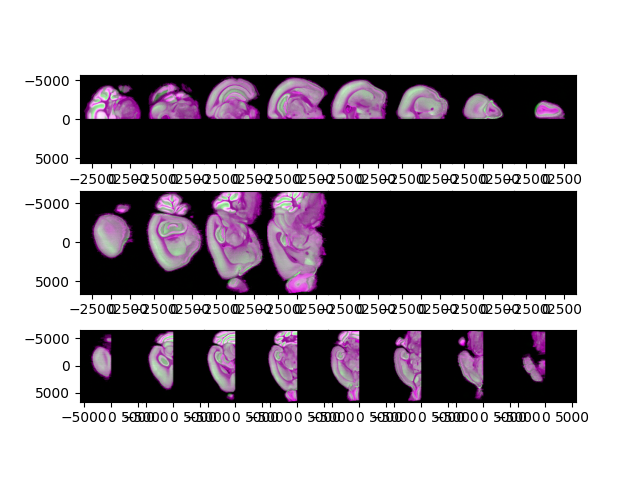

In [17]:
Iat = []
for atlas_name in atlas_names:
    xIat,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))

    # Will zero-out atlas image for the hemisphere we are NOT aligning
    if orientation == 'R': # For images only containing a RIGHT  hemisphere
        I_[:,:,:int(np.shape(I_)[2]/2),:] = np.zeros([np.shape(I_)[0],np.shape(I_)[1],int(np.shape(I_)[2]/2),np.shape(I_)[3]])
    elif orientation == 'L': # For images only containing a LEFT hemisphere (+1 brings back fig[1,2])
        I_[:,:,int(np.shape(I_)[2]/2 + 1):,:] = np.zeros([np.shape(I_)[0],np.shape(I_)[1],int(np.shape(I_)[2]/2 - 1),np.shape(I_)[3]])
    else:
        print(f'{brain} contains whole-brain images, not hemispheres')
        
    Iat.append(I_)
    
Iat = np.concatenate(Iat)   
Iat[0] = Iat[0]**0.25
Iat[0] /= np.mean(np.abs(Iat[0]))
dIat = np.array([x[1] - x[0] for x in xIat])
XIat = np.stack(np.meshgrid(*xIat,indexing='ij'),0)

fig,ax = emlddmm.draw(Iat,xIat,vmin=0,n_slices=8)
fig.canvas.draw()

# collect data for one slab only to test new neurons

Text(0.5, 1.0, 'HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_02_2023-02-24_12.06.13_FusionStitcher_ch_0_pow_[0.125]_down')

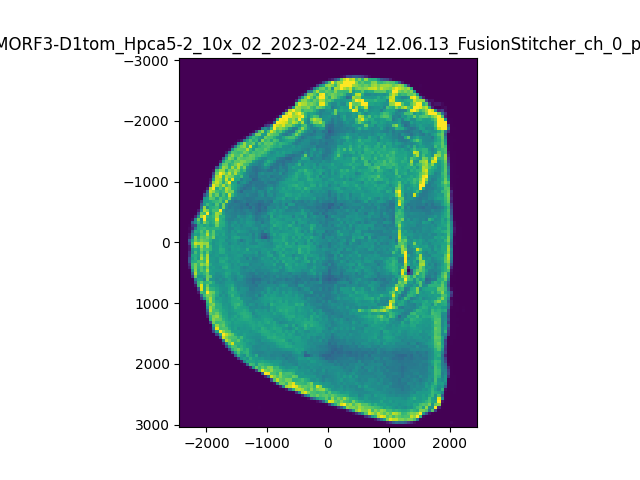

In [18]:
low_ind = 1

# load the low res image
image_low_file = image_low_files[low_ind]
if 'MQC' in brain or 'KO' in brain_path:
    image_low_key = image_low_file.split('_')[-9]
else:
    image_low_key = image_low_file.split('_')[-6]
    
data = np.load(image_low_file,allow_pickle=True)
I = data['I']

# We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
xI = [d - np.mean(d) for d in data['xI']]

if len(xI[-1]) != I.shape[-1]:
    # add one to the end
    xI[-1] = np.concatenate((xI[-1],xI[-1][-1][None] + (xI[-1][1]-xI[-1][0])))
    
XI = np.stack(np.meshgrid(*xI,indexing='ij'))
# sometimes, I and xI do not match in size!
key = 'W' if 'W' in data else 'w'
WI = data[key]
dI = [xi[1] - xi[0] for xi in xI]
# get extent and draw it
extentlow0 = (xI[-1][0]-dI[-1],xI[-1][-1]+dI[-1],xI[-2][-1]+dI[-2],xI[-2][0]-dI[-2])
extentlow1 = (xI[-2][0]-dI[-2],xI[-2][-1]+dI[-2],xI[-3][-1]+dI[-3],xI[-3][0]-dI[-3])
extentlow2 = (xI[1][0]-dI[1],xI[1][-1]+dI[1],xI[0][-1]+dI[0],xI[0][0]-dI[0])
I0 = np.max(I,0)
I1 = np.max(I,1)
I2 = np.max(I,2)
fig,ax = plt.subplots()
vminI = np.quantile(I[WI>0.999],0.1)
vmaxI = np.quantile(I[WI>0.999],0.999)
ax.imshow(I0,extent=extentlow0,vmin=vminI,vmax=vmaxI)
ax.set_title(splitext(split(image_low_file)[-1])[0])


In [19]:
image_low_files

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_01_2023-02-24_11.52.21_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_02_2023-02-24_12.06.13_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_03_2023-02-24_12.21.08_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_04_2023-02-24_13.42.12_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MOR

In [20]:
## now we find the corresponding high res files
#image_high_files = glob(join(image_dir,'*30x_*' + image_low_key + '*_channel_0_down.npz'))
## there should be two
#image_high_keys = [n.split('_')[-4] for n in image_high_files]

In [21]:
image_low_key

'02'

In [22]:
def temp_filter(x):
    if 'cropped' in x or 'Cropped' in x or 'neurite' in x:
        return False
    return True

# again we need to walk
# I want ch_1, but I'm stuck wiht 0 for now
# really? I think for tme08 I want 0 but I'm stuck with 1
# note this is what image I load, not which transform
channel = channel_10_to_30
#channel = 1 # nicer looking images
image_high_files = []
for dirpath, dirnames, filenames in walk(image_dir):
    if 'TME07-1' in brain:
        files = glob(join(dirpath,f'*{image_low_key}*30x*channel_{channel}*.npz'))
    elif 'MQC' in brain:
        files = glob(join(dirpath,f'*30X*{image_low_key}*ch_{channel}*.npz'))
    elif brain in 'Hpca5-2':
        files = glob(join(dirpath,f'*30x_Str_{image_low_key}*ch_{channel}*.npz'))
    else:
        files = glob(join(dirpath,f'*30x*{image_low_key}*ch_{channel}*.npz'))
    image_high_files.extend(files)
image_high_files.sort()

# NOTE: There are some files called "cropped" I don't want them
# Note from Andrew: Some files also called 'Cropped' and 'neurite'
# image_high_files = list(filter(lambda x: 'cropped' and 'Cropped' not in x, image_high_files))
# image_high_files = list(filter(lambda x: 'cropped' and 'Cropped' and 'neurite' not in x, image_high_files))
image_high_files = list(filter(temp_filter, image_high_files))

image_high_files

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/30x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_30x_Str_02_2023-03-07_12.33.19_FusionStitcher_ch_0_pow_[0.125]_down.npz']

### Get list of all high res files

In [23]:
all_image_high_files = []

for dirpath, dirnames, filenames in walk(image_dir):
    if 'TME07-1' in brain:
        files = glob(join(dirpath,f'*{image_low_key}*30x*channel_{channel}*.npz'))
    elif 'MQC' in brain:
        files = glob(join(dirpath,f'*30X*{image_low_key}*ch_{channel}*.npz'))
    else:
        files = glob(join(dirpath,f'*30x*{image_low_key}*ch_{channel}*.npz'))
    all_image_high_files.extend(files)
all_image_high_files.sort()

all_image_high_files = list(filter(lambda x: 'cropped' and 'Cropped' not in x, all_image_high_files))

In [24]:
all_image_high_files

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/30x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_30x_Str_01_2023-03-07_10.43.45_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/30x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_30x_Str_02_2023-03-07_12.33.19_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/30x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_30x_Str_03_2023-03-07_14.40.29_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/30x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_30x_Str_04_2023-03-07_16.44.33_FusionStitcher_ch_0_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_Drag

### Check that Voxel Locations == Number of Voxels

In [25]:
# load the data
Js = []
xJs = []
Ws = []
dJs = []
DJs = []
print('Low res files')
for fname in image_low_files:
    print(fname)
    data = np.load(fname,allow_pickle=True)
    Js.append(data['I'][None])    

    # We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
    xJs.append([d-np.mean(d) for d in data['xI']])

    if 'W' in data or 'w' in data:
        if 'W' in data:
            key = 'W'
        else:
            key = 'w'
        W_ = data[key]
        if W_.ndim == 4:
            W_ = W_[0]
        Ws.append(W_)
    else:
        #Ws.append(np.zeros_like(Js[0]))
        # I think this should be ones
        Ws.append(np.ones_like(Js[0]))
    
    
    # we need to normalize to [0,1]
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.05)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    #print(mymin,mymax)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    # I'd like to squash the bright signal
    signJ = np.sign(Js[-1])
    Js[-1] = signJ*abs(Js[-1])**0.25

    
    # we need to normalize to [0,1] again!
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.05)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    #print(mymin,mymax)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    # after scaling I'm going to zero out the low signals (new feb 2 2023)
    Js[-1][Js[-1]<0.0] = 0.0
    # also I think the weights are not strong enough
    Ws[-1][Ws[-1]<0.999] = 0.0
    
    dJs.append([x[1]-x[0] for x in xJs[-1]])
    DJs.append(np.prod(dJs[-1]) )
    
    # note, sometimes xJs don't match Js
    s = -1
    if len(xJs[-1][s]) != Js[-1].shape[s]:
        print('mismatch')
        print(f'x size {len(xJs[-1][s])} doesn\'t match J size {Js[-1].shape[s]}')
        n = Js[-1].shape[s] - len(xJs[-1][s]) 
        d = xJs[-1][s][1] - xJs[-1][s][0]
        xJs[-1][s] = np.concatenate((xJs[-1][s],[xJs[-1][s][-1]+d ]))

Js = []
xJs = []
Ws = []
dJs = []
DJs = []
print('\nHigh res files')
for fname in all_image_high_files:
    print(fname)
    data = np.load(fname,allow_pickle=True)
    Js.append(data['I'][None])    

    # We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
    xJs.append([d-np.mean(d) for d in data['xI']])
    
    if 'W' in data or 'w' in data:
        if 'W' in data:
            key = 'W'
        else:
            key = 'w'
        W_ = data[key]
        if W_.ndim == 4:
            W_ = W_[0]
        Ws.append(W_)
    else:
        #Ws.append(np.zeros_like(Js[0]))
        # I think this should be ones
        Ws.append(np.ones_like(Js[0]))
    
    
    # we need to normalize to [0,1]
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.05)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    #print(mymin,mymax)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    # I'd like to squash the bright signal
    signJ = np.sign(Js[-1])
    Js[-1] = signJ*abs(Js[-1])**0.25

    
    # we need to normalize to [0,1] again!
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.05)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    #print(mymin,mymax)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    # after scaling I'm going to zero out the low signals (new feb 2 2023)
    Js[-1][Js[-1]<0.0] = 0.0
    # also I think the weights are not strong enough
    Ws[-1][Ws[-1]<0.999] = 0.0
    
    dJs.append([x[1]-x[0] for x in xJs[-1]])
    DJs.append(np.prod(dJs[-1]) )
    
    # note, sometimes xJs don't match Js
    s = -1
    if len(xJs[-1][s]) != Js[-1].shape[s]:
        print('mismatch')
        print(f'x size {len(xJs[-1][s])} doesn\'t match J size {Js[-1].shape[s]}')
        n = Js[-1].shape[s] - len(xJs[-1][s]) 
        d = xJs[-1][s][1] - xJs[-1][s][0]
        xJs[-1][s] = np.concatenate((xJs[-1][s],[xJs[-1][s][-1]+d ]))

Low res files
/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_01_2023-02-24_11.52.21_FusionStitcher_ch_0_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_02_2023-02-24_12.06.13_FusionStitcher_ch_0_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_03_2023-02-24_12.21.08_FusionStitcher_ch_0_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_downsampled/10x/ch_0_pipeline_building/HpcaKO-Camk-MORF3-D1tom_Hpca5-2_10x_04_2023-02-24_13.42.12_FusionStitcher_ch_0_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/KO-Het_MORF/Hp

In [26]:
if 'TME07-1' in brain:
    image_high_keys = [n.split('_')[-4] for n in image_high_files]
elif 'MQC' in brain or 'KO' in brain_path:
    image_high_keys = [n.split('_')[-9] for n in image_high_files]
else:
    image_high_keys = [n.split('_')[-6] for n in image_high_files]
image_high_keys

['02']

In [27]:
# now we get all the neurons
neuron_files = []
for dirpath, dirnames, filenames in walk(neuron_dir):
    # print(f'{dirpath}, {dirnames}, {filenames}')
    for filename in filenames:
        if '.swc' in filename:
            neuron_files.append(join(dirpath,filename))


image_high_ind = 0
# image_high_ind = 1
image_high_file = image_high_files[image_high_ind]
image_high_key = image_high_keys[image_high_ind]

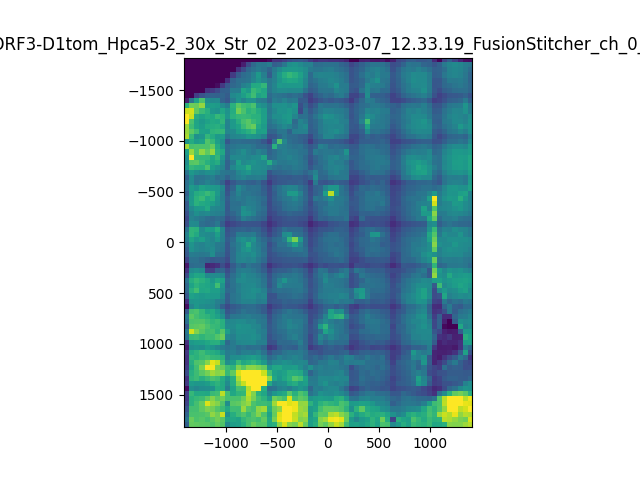

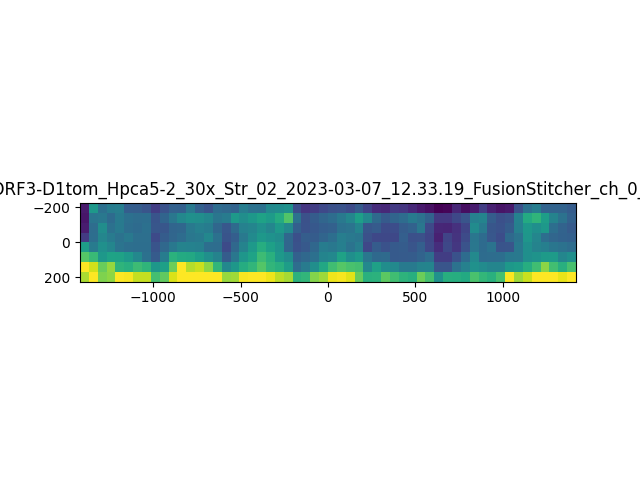

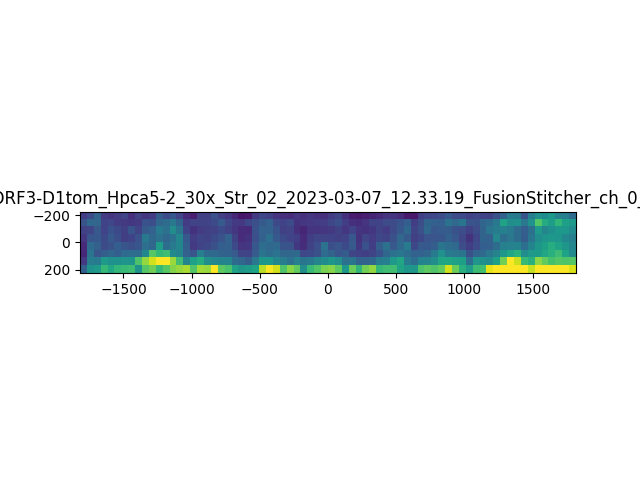

In [28]:
# load the image    
Vall = []
Eall = []
data = np.load(image_high_file,allow_pickle=True)
J = data['I']

# We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
xJ = [d - np.mean(d) for d in data['xI']]

key = 'W' if 'W' in data else 'w'
WJ = data[key]
xJ0 = [xi - xi[0] for xi in xJ]
dJ = [xi[1] - xi[0] for xi in xJ]
#vminJ = np.quantile(J[WJ>0.9],0.001)
if channel == 1 and '04A' in image_high_file and False:
    J[J<1.5] = np.min(J[J>=1.5])
    J -= np.min(J)
    J /= np.max(J)
else:
    vminJ = np.quantile(J[WJ>0.9],0.1)
    vmaxJ = np.quantile(J[WJ>0.9],0.999)

# for 0 we need to do 2,1
# for 1 we need to do 2,0
# for 2 we need to do 1,0
extenthigh0 = (xJ[-1][0]-dI[-1],xJ[-1][-1]+dI[-1],xJ[-2][-1]+dI[-2],xJ[-2][0]-dI[-2])
extenthigh1 = (xJ[2][0]-dI[2],xJ[2][-1]+dI[2],xJ[0][-1]+dI[0],xJ[0][0]-dI[0])
extenthigh2 = (xJ[1][0]-dI[1],xJ[1][-1]+dI[1],xJ[0][-1]+dI[0],xJ[0][0]-dI[0])

J0 = np.max(J,0)
J1 = np.max(J,1)
J2 = np.max(J,2)
fig0,ax0 = plt.subplots()
ax0.imshow(J0,extent=extenthigh0,vmin=vminJ,vmax=vmaxJ)
ax0.set_title(splitext(split(image_high_file)[-1])[0])
fig0.canvas.draw()

fig1,ax1 = plt.subplots()
ax1.imshow(J1,extent=extenthigh1,vmin=vminJ,vmax=vmaxJ)
ax1.set_title(splitext(split(image_high_file)[-1])[0])
fig1.canvas.draw()

fig2,ax2 = plt.subplots()
ax2.imshow(J2,extent=extenthigh2,vmin=vminJ,vmax=vmaxJ)
ax2.set_title(splitext(split(image_high_file)[-1])[0])
fig2.canvas.draw()



### (Solved) Problem 1: files_filter is empty after running cell => empty V => empty phiiVall => ValueError several cells down

In [29]:

files_filter = list(filter(lambda x: image_high_key in x, neuron_files))
# now we load them
V = []
E = []
dJ0 = np.array([0.2,0.2,1.0])
for file in files_filter:
    
    # .swc files for TME12-1 contain a comment on line 1
    if brain in ['TME12-1'] or 'MQC' in brain or 'KO' in brain_path:
        v_,e_,r_ = load_swc(file, skip=1)
    else:
        v_,e_,r_ = load_swc(file)
    
    #v_ = v_ - v_[0] # maybe this? this seems to give good results ( I did this one with old swc)
    ##v_ = v_[0] - v_ # maybe this? (I didn't do this one)
    
    # I think I need to scale by voxel size
    v_ *= dJ0  
        
    #xyzoff = (np.array([int(x[1:]) for x in splitext(split(file)[-1])[0].split('_')[-3:]]))*dJ0
    xyzoff = 0.0 # I think no offset here anymore, not sure
    
    
    
    v_ += xyzoff
    # also account for the coordinate offset
    # a zero should correspond to an x[0]
    v_ += np.array([xJ[2][0],xJ[1][0],xJ[0][0]])
    V.append(v_)
    E.append(e_)


for i in range(len(V)):
    v_ = V[i]
    e_ = E[i]
    #colors=v_[e_][:,0,0]
    #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
    colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
    colors[:,-1] = 0.5
    lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors)
    lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors)
    lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors)

    ax0.add_collection(lines0)
    ax1.add_collection(lines1)
    ax2.add_collection(lines2)
    
Vall.append(V)
Eall.append(E)    

# in the cell below, I have XI as my transform and the inverse
# maybe this is leading to interpolation problems
the neurons are defined with respect to xJ, the high res images
we should therefore define the transform on this domain

/tmp/ipykernel_2741744/2873668131.py:30: RuntimeWarning: invalid value encountered in divide
  toshow = ((JtoI)/(WJtoI))[None]
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/tmp/ipykernel_2741744/2873668131.py:99: RuntimeWarning: invalid value encountered in sqrt
  ax.imshow(Ishow[...,None]**0.5*np.array([[[1.0,0.0,0.0]]]),vmin=0,vmax=1,extent=extentlow0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_2741744/2873668131.py:100: RuntimeWarning: invalid value encountered in sqrt
  ax.imshow(toshowmax[...,None]**0.5*np.array([[[0.0,1.0,0.0]]]),vmin=0,vmax=1,alpha=0.4,cmap='Greens',extent=extentlow0)
/tmp/ipykernel_2741744/2873668131.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0

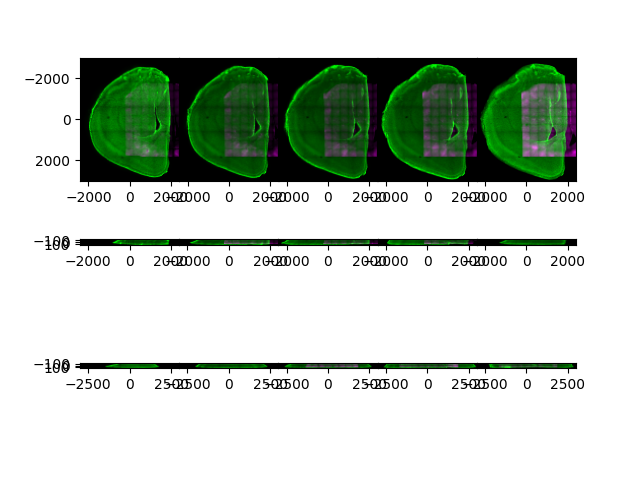

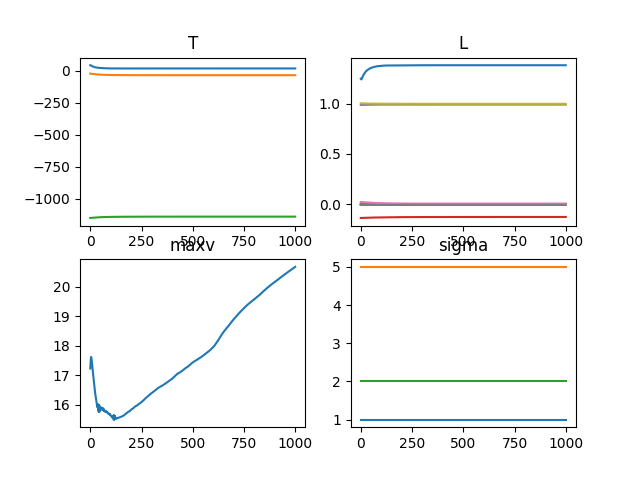

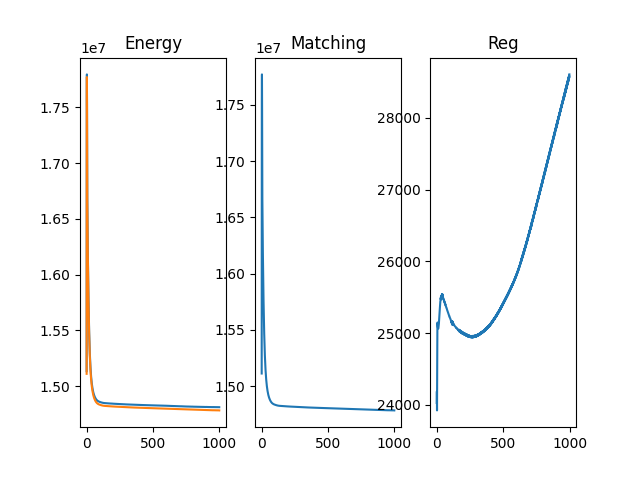

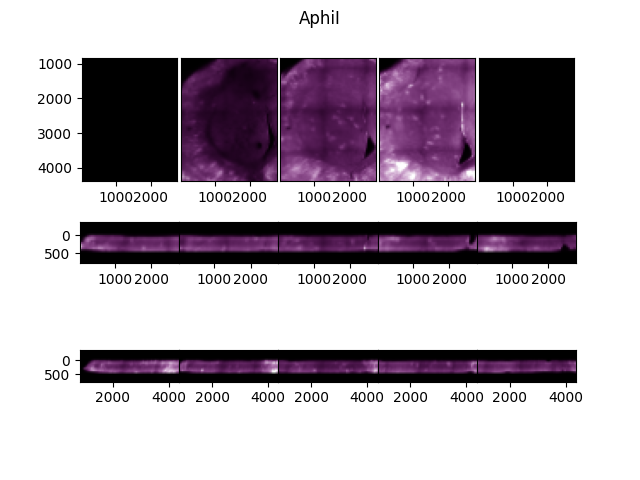

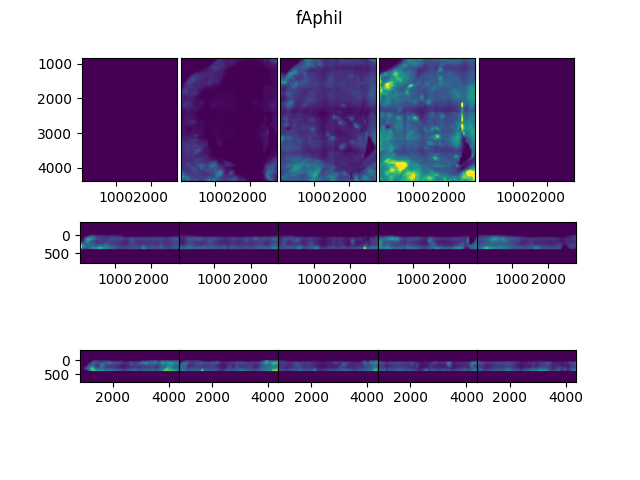

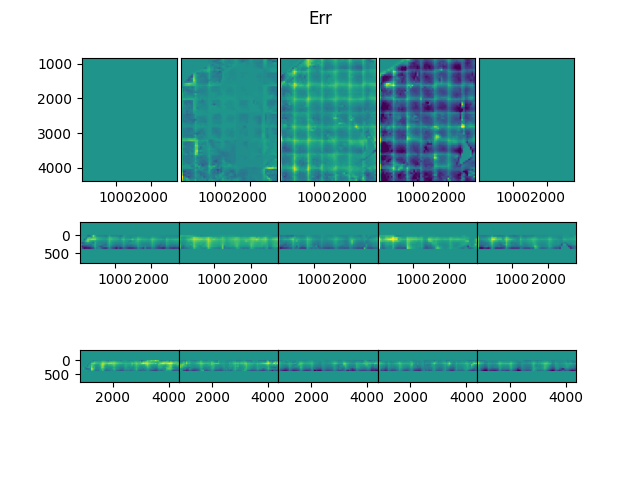

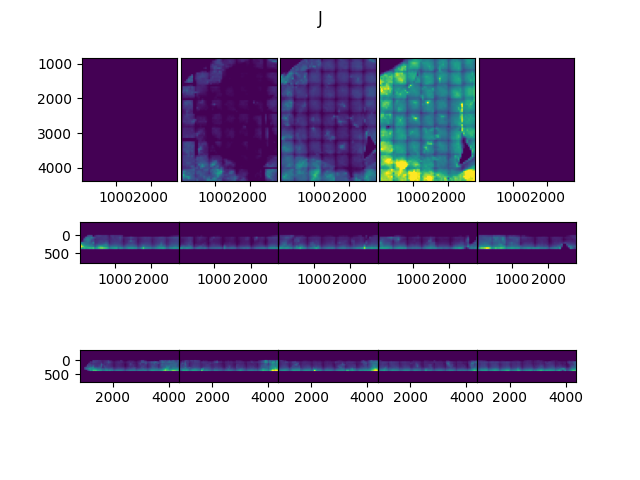

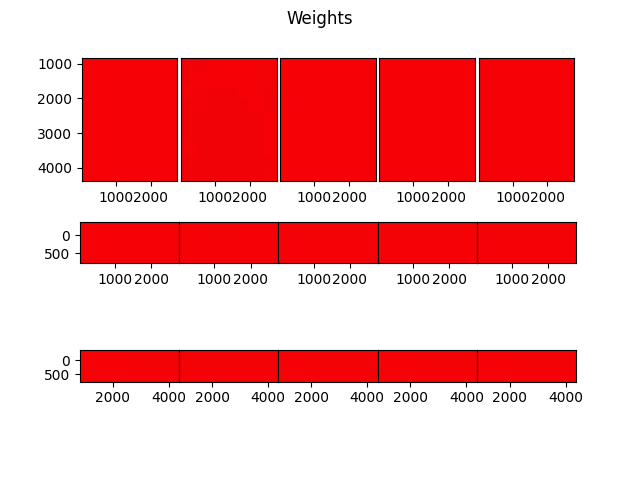

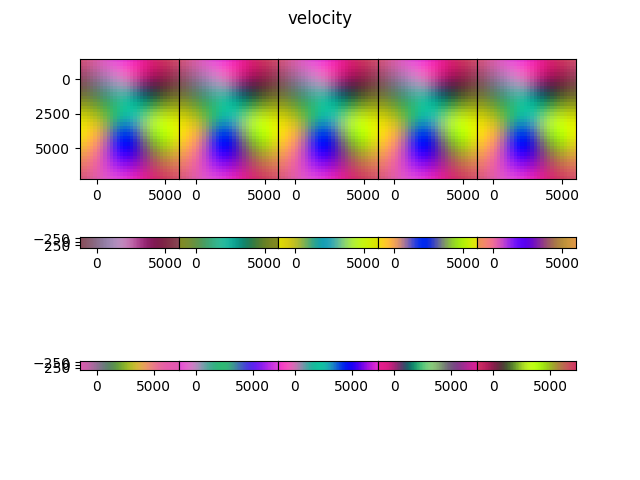

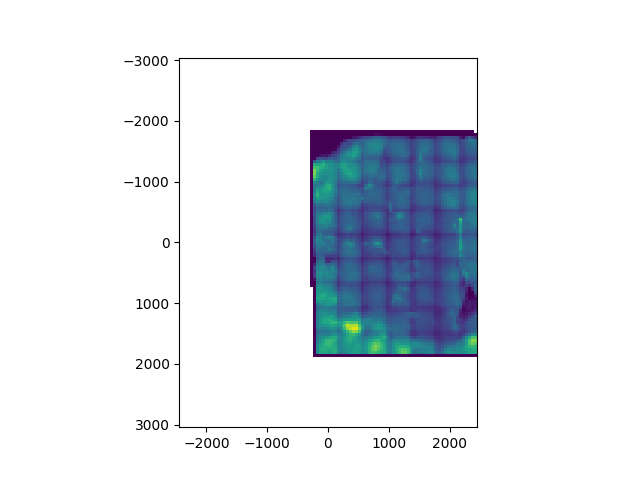

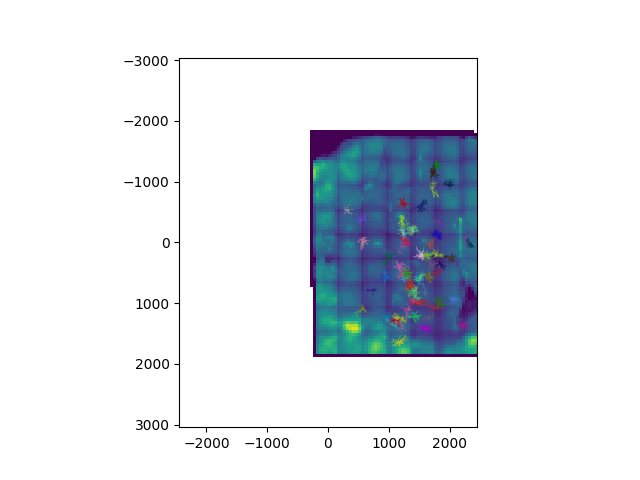

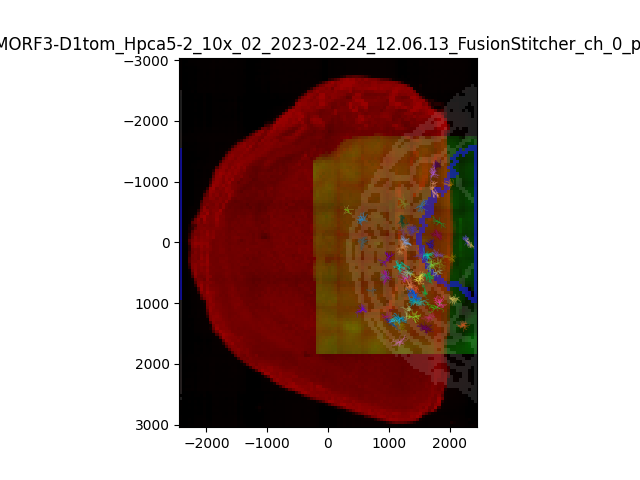

In [30]:
# NOTE, this cell just does one example slice.  it is useful for testing or debugging.  below we will do all slices

# Allows notebook to run w/o error since we are missing the 01A transformation file for TME07-1_01A
if image_high_key == '01A' and brain == 'TME07-1':
    image_high_key = '01B'

# now transform the volume into the low res image
# we'll accumulate a weight and the image
# to do this we have to load the transformations
fig_together = plt.figure()
JtoI = np.zeros_like(I)
WJtoI = np.zeros_like(WI)
phiiVall = []

# Load dict containing 10x-to-30x registration for 'image_high_key' AND print out 8 figures
###### reg_file = glob(join(reg_dir, '*' + image_high_key + '*' + '_ch_' + str(channel_10_to_30) + '*.npz'))[0]
reg_file = glob(join(reg_dir, '*' + image_high_key + '*' + '*.npz'))[0]
reg_data = np.load(reg_file,allow_pickle=True)
# use a fallback for loading with version incompatibility
try:
    out = reg_data['out'].item()
except:
    out = backup_unpickle(reg_file)
    
tform = emlddmm.compose_sequence([emlddmm.Transform(out['v'],domain=out['xv']),emlddmm.Transform(out['A'])],XI)
phiiJ = emlddmm.apply_transform_float(xJ,J[None],tform,padding_mode='zeros').numpy()
phiiW = emlddmm.apply_transform_float(xJ,WJ[None],tform,padding_mode='zeros').numpy()    
JtoI += (phiiJ[0] - vminJ)/(vmaxJ-vminJ)*phiiW[0] #not sure if I should do this for normalization    
WJtoI += phiiW[0]
toshow = ((JtoI)/(WJtoI))[None]
##### toshow /= np.max(JtoI)

# Overlays 30x image on transformed 10x image
emlddmm.draw(np.stack((toshow[0],(I-vminI)/(vmaxI-vminI),toshow[0])),xI,vmin=0,vmax=1,fig=fig_together)
fig_together.canvas.draw()

# now we have to map the neurons in, and draw them
# adding XJ this is a change
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'))
tform = emlddmm.compose_sequence([emlddmm.Transform(out['A'],direction='b'),emlddmm.Transform(out['v'],direction='b',domain=out['xv'])],XJ)
#tform = emlddmm.compose_sequence([emlddmm.Transform(out['A'],direction='b'),emlddmm.Transform(out['v'],direction='b',domain=out['xv'])],XI)
phiiV = []
for vi in V:
    # note swap xyz to zyx and back
    phiiV.append( emlddmm.interp(xJ,tform,vi.T[::-1,:,None,None].astype(np.float32))[...,0,0].T.numpy()[...,::-1] )
    #phiiV.append( emlddmm.interp(xI,tform,vi.T[::-1,:,None,None].astype(np.float32))[...,0,0].T.numpy()[...,::-1] )
phiiVall.append(phiiV)



# Displays 30x MIP above empty background of the same size as the 10x image (create a max projection, accounting for nans)
fig,ax = plt.subplots()
toshowmax = np.array(toshow[0,0])
nanind = np.isnan(toshowmax)
ax.imshow(toshowmax,vmin=0,vmax=1,extent=extentlow0)
fig.canvas.draw()
for i in range(1,toshow.shape[1]):
    toshownew = np.array(toshow[0,i])
    # we update toshowmax if there are two things    
    # if they are both nan, set to nan    
    # if the old one is nan and the new one is not, set to the new one
    # if the old one is not nan and the new one is, set to the new one
    # if both are not nan, set to the max
    # recall, any inequality involving nan gives false
    nanindnew = np.isnan(toshownew)
    inds = np.logical_or( toshownew > toshowmax , np.logical_not(nanindnew)*nanind  )
    toshowmax[inds] = toshownew[inds]

    nanind = np.isnan(toshowmax)

ax.cla()
ax.imshow(toshowmax,vmin=0,vmax=1,extent=extentlow0)
#plt.pause(0.1)
fig.canvas.draw()


# Displays 30x MIP + neurons above empty background of the same size as the 10x image (show them with neurons)
fig,ax = plt.subplots()
ax.imshow(toshowmax,vmin=0,vmax=1,extent=extentlow0)
for j in range(len(phiiVall)):
    for i in range(len(phiiVall[j])):
        v_ = phiiVall[j][i]
        e_ = Eall[j][i]
        #colors=v_[e_][:,0,0]
        #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
        colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
        colors[:,-1] = 0.5
        lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors,linewidths=0.5)
        #lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors,linewidths=0.5)
        #lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors,linewidths=0.5)

        ax.add_collection(lines0)
        #ax1.add_collection(lines1)
        #ax2.add_collection(lines2)

# Displays 30x MIP + neurons + 10x MIP (show again with images)
Ishow = (np.max(I,0) - vminI)/(vmaxI-vminI)
fig,ax = plt.subplots()
ax.imshow(Ishow[...,None]**0.5*np.array([[[1.0,0.0,0.0]]]),vmin=0,vmax=1,extent=extentlow0)
ax.imshow(toshowmax[...,None]**0.5*np.array([[[0.0,1.0,0.0]]]),vmin=0,vmax=1,alpha=0.4,cmap='Greens',extent=extentlow0)

for j in range(len(phiiVall)):
    for i in range(len(phiiVall[j])):
        v_ = phiiVall[j][i]
        e_ = Eall[j][i]
        #colors=v_[e_][:,0,0]
        #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
        colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
        colors[:,-1] = 0.5
        lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors,linewidths=0.5)
        #lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors)
        #lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors)

        ax.add_collection(lines0)
        #ax1.add_collection(lines1)
        #ax2.add_collection(lines2)
ax.set_title(f'{splitext(basename(image_low_file))[0]}')



# in addition, we want to map the atlas onto this slice
tform_low_to_at = emlddmm.compose_sequence([
        emlddmm.Transform(dataat['v'].transpose(0,-1,1,2,3),domain=dataat['xv'],direction='b'),
        emlddmm.Transform(dataat['A'],direction='b'),
        emlddmm.Transform(dataat['TJ'][low_ind],direction='b'),
        emlddmm.Transform(dataat['vJ'][low_ind].transpose(0,-1,1,2,3),domain=dataat['xvJ'][low_ind],direction='b'),
        emlddmm.Transform(dataat['AJ'][low_ind],direction='b')
    ][::-1],XI)

# get segmentation labels
from scipy.interpolate import interpn
Stformed = interpn(xS,S[0],tform_low_to_at.permute(1,2,3,0),bounds_error=False,fill_value=0,method='nearest')

# mode projection is like a max projection here
from scipy.stats import mode
m,c = mode(Stformed,axis=0,)
m = m[0]

# from m we'll get boundaries
mb = 1 - (m == np.roll(m,shift=1,axis=0))*(m == np.roll(m,shift=1,axis=1))*(m == np.roll(m,shift=-1,axis=0))*(m == np.roll(m,shift=-1,axis=1))
mb = mb*1.0
# and add it to the image
ax.imshow(np.stack((mb,mb,mb,mb*0.125),-1),interpolation='none',extent=extentlow0,cmap='gray')

# now cp
mcp = np.zeros_like(m)
for id_ in cp_ids:
    mcp = np.logical_or(mcp,m==id_)
mcpb = 1 - (mcp == np.roll(mcp,shift=1,axis=0))*(mcp == np.roll(mcp,shift=1,axis=1))*(mcp == np.roll(mcp,shift=-1,axis=0))*(mcp == np.roll(mcp,shift=-1,axis=1))
mcpb = mcpb*1.0
ax.imshow(np.stack((mcpb*0,mcpb*0,mcpb,mcpb*0.5),-1),interpolation='none',extent=extentlow0,cmap='gray')
# note, if you want a fillin, use mcp instead of mcpb

# TODO replace this output location with something we can specify
# actually this does not need to be uncommented, the figure should get saved below
#plt.savefig(f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/step3QC/10x_30x_neuron_{image_high_key}.jpg')

In [31]:
raise Exception('Stop')

Exception: Stop

In [ ]:
np.mean([[1,2,3],[4,3,5]], axis=0)

In [ ]:
print('is this running?')

In [ ]:
fig,ax = plt.subplots()
ax.imshow(np.stack((mb,mb,mb,mb),-1)*1.0,interpolation='none',extent=extentlow0,cmap='gray',alpha=0.5)

In [ ]:
[k for k in out]

In [ ]:
# check in 3D
vsave = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(0,0)
for j in range(len(phiiVall)):
    for i in range(len(phiiVall[j])):
        v_ = phiiVall[j][i]
        #v_ = Vall[j][i]
        e_ = Eall[j][i]
        #colors=v_[e_][:,0,0]
        #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
        colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
        colors[:,-1] = 0.5
        lines0 = Line3DCollection(v_[e_],colors=colors,linewidths=0.5)
        #lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors)
        #lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors)

        ax.add_collection(lines0)
        #ax1.add_collection(lines1)
        #ax2.add_collection(lines2)
        # we don't want nans!
        if np.any(np.isnan(v_)): continue
        vsave.append(v_)
        
datasave_ = np.concatenate(vsave)
vmin = np.min(datasave_,0)
vmax = np.max(datasave_,0)
r = vmax-vmin
rmax = np.max(r)
c = (vmin+vmax)/2
vmin = c-rmax/2
vmax = c+rmax/2
ax.set_xlim(vmin[0],vmax[0])
ax.set_ylim(vmin[1],vmax[1])
ax.set_zlim(vmin[2],vmax[2])        



# check in 3D
vsave = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(0,0)
for j in range(len(phiiVall)):
    for i in range(len(phiiVall[j])):
        v_ = phiiVall[j][i]
        v_ = Vall[j][i]
        e_ = Eall[j][i]
        #colors=v_[e_][:,0,0]
        #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
        colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
        colors[:,-1] = 0.5
        lines0 = Line3DCollection(v_[e_],colors=colors,linewidths=0.5)
        #lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors)
        #lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors)

        ax.add_collection(lines0)
        #ax1.add_collection(lines1)
        #ax2.add_collection(lines2)
        if np.any(np.isnan(v_)): continue
        vsave.append(v_)
        
datasave_ = np.concatenate(vsave)
vmin = np.min(datasave_,0)
vmax = np.max(datasave_,0)
r = vmax-vmin
rmax = np.max(r)
c = (vmin+vmax)/2
vmin = c-rmax/2
vmax = c+rmax/2
ax.set_xlim(vmin[0],vmax[0])
ax.set_ylim(vmin[1],vmax[1])
ax.set_zlim(vmin[2],vmax[2])        

In [ ]:
# it looks like some of them got completely flat
# maybe this is due to boundary conditions on the diffeomorphism?
# still under investigation

In [ ]:
# raise Exception('stop')

# the loop below will collect and process data for all slabs

### Problem 2: ValueError (See output below cell)
*May resolve itself after solving Problem 1

In [ ]:
# initialize variables to save
# I need
# my low res slab image which will be incremented
# my high res slab image
# my neurons
# my neuron labels

# these variables will store all slabs
neurons_orig = []
neurons_one_step = []
neurons = []
neuron_labels = []
neuron_edges = []
neuron_labels_noise = []
neuron_count = 0
images = np.zeros((3,Iat.shape[1],Iat.shape[2],Iat.shape[3]))
set_v_to_zero = False
files_all = [] 
# we get all the files at once based on this output format
# now we get all the neurons, this is the same each time
files_ = []
for dirpath, dirnames, filenames in walk(neuron_dir):
    for filename in filenames:
        if 'TME07-1' in brain and ('01A' in filename or '01B' in filename):
            continue
        if '.swc' in filename:
            files_.append(join(dirpath,filename))

# NOTE
# in certain cases, we could not map some of the blocks, if there were problems with the tissue
# in one cases, I added a '-1' added to prevent looping through slice 9 (Missing images)
# however, we need a more general way of doing this, because different cases may have different missing
# or poor quality slabs
# in some cases, there was a high resolution image missing
# but only in very few cases was there a low resolution missing
# we think it's only for TME 07
# we need to do two things to fix this
# first, loop over all the files for low ind below (don't subtract 1)
# second, when loading transforms, we should index them by "low_ind" and not "low_ind-1" 
# (this shows up in 2 places, at_to_low, and low_to_at)
# BUT, in special cases, like TME07, we will need to fix this
# TODO: we need to check what happens if we're missing a high res file
# NOTE: for tme08, we might be missing a high res image

# Several TME brains missing 30x images for slice 09
if brain in ['TME09-1', 'TME10-1', 'TME10-3', 'TME12-1', 'Hpca5-2']:
    all_slice_idx = range(0,len(image_low_files))[:-1]
elif brain in ['TME07-1']:
    all_slice_idx = range(0,len(image_low_files))[1:-1]
else:
    all_slice_idx = range(0,len(image_low_files))

for low_ind in all_slice_idx: 

    # # Skip first slice of TME07-1 due to missing data
    # if 'TME07-1' in brain and low_ind == 0:
    #     continue
    
    # load the low res image
    image_low_file = image_low_files[low_ind]
    if 'TME07-1' in brain:
        image_low_key = image_low_file.split('_')[-4] # TODO check this if output format changes
    elif 'MQC' in brain or 'KO' in brain_path:
        image_low_key = image_low_file.split('_')[-9]
    else:
        image_low_key = image_low_file.split('_')[-6] # TODO check this if output format changes
    data = np.load(image_low_file,allow_pickle=True)
    I = data['I']

    # We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
    xI = [d - np.mean(d) for d in data['xI']]
    
    # check the size
    if len(xI[-1]) != I.shape[-1]:        
        xI[-1] = np.concatenate((xI[-1],xI[-1][-1][None] + (xI[-1][1]-xI[-1][0])))
    
    XI = np.stack(np.meshgrid(*xI,indexing='ij'))
    key = 'W' if 'W' in data else 'w'
    WI = data[key]
    dI = [xi[1] - xi[0] for xi in xI]
    
    # get extent and draw it
    extentlow0 = (xI[2][0]-dI[2],xI[2][-1]+dI[2],xI[1][-1]+dI[1],xI[1][0]-dI[1])
    extentlow1 = (xI[2][0]-dI[2],xI[2][-1]+dI[2],xI[0][-1]+dI[0],xI[0][0]-dI[0])
    extentlow2 = (xI[1][0]-dI[1],xI[1][-1]+dI[1],xI[0][-1]+dI[0],xI[0][0]-dI[0])
    
    
    I0 = np.max(I,0)
    I1 = np.max(I,1)
    I2 = np.max(I,2)
    fig,ax = plt.subplots()
    # vminI = np.min(I[WI>0.9])
    vminI = np.quantile(I.ravel(),0.4) # Made change on 6/27/23 in order to make each slice output figure show the 10x, 30x, AND neuron
    vmaxI = np.max(I[WI>0.9])
    ax.imshow(I0,extent=extentlow0,vmin=vminI,vmax=vmaxI)
    ax.set_title(splitext(split(image_low_file)[-1])[0])
    
    
    # now we find the corresponding high res files
    channel_high = channel_10_to_30
    image_high_files = []
    for dirpath, dirnames, filenames in walk(image_dir):
        if 'TME07-1' in brain:
            files = glob(join(dirpath,f'*30x*{image_low_key}*channel_{channel_high}*.npz'))
        elif 'MQC' in brain:
            files = glob(join(dirpath,f'*30X_Str_{image_low_key}*ch_{channel_high}*.npz'))
        elif brain in 'Hpca5-2':
            files = glob(join(dirpath,f'*30x_Str_{image_low_key}*ch_{channel}*.npz'))
        else:
            files = glob(join(dirpath,f'*30x*{image_low_key}*ch_{channel_high}*.npz'))
        image_high_files.extend(files)
    image_high_files.sort()
    image_high_files = list(filter(temp_filter, image_high_files))
    

    # there should be two
    if 'TME07-1' in brain:
        image_high_keys = [n.split('_')[-4] for n in image_high_files]
    elif 'MQC' in brain or 'KO' in brain_path:
        image_high_keys = [n.split('_')[-9] for n in image_high_files]
    else:
        image_high_keys = [n.split('_')[-6] for n in image_high_files]
    
    # we'll extract this slice
    files = list(filter(lambda x: '_'+image_low_key in x, files_))
    files_all.append(files)


    
    # now we start processing
    fig_together = plt.figure()
    JtoI = np.zeros_like(I)
    WJtoI = np.zeros_like(WI)
    
    # note these variables with an "all" suffix will store left and right
    phiiVall = []
    Vall = []
    Eall = []
    Rall = []
    neuron_labels_all_QC = []
    # now we will need to loop through, the files above
    # print(f'ihk early: {image_high_key}')
    print(f'all ihk (idx: {low_ind}): {image_high_keys}')
    # print(f'all ihk files (idx: {low_ind}): {image_high_files}')
    print(f'image_low_key: {image_low_key}')
    for image_high_file,image_high_key in zip(image_high_files,image_high_keys):

        # load the image    
        data = np.load(image_high_file,allow_pickle=True)
        J = data['I']

        # We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
        xJ = [d - np.mean(d) for d in data['xI']]
    
        key = 'W' if 'W' in data else 'w'
        WJ = data[key]
        xJ0 = [xi - xi[0] for xi in xJ]
        dJ = [xi[1] - xi[0] for xi in xJ]
        if channel == 1 and '04A' in image_high_file and False:
            J[J<1.5] = np.min(J[J>=1.5])
            J -= np.min(J)
            J /= np.max(J)
        elif channel == 0 and  '04A' in image_high_file  and False:
            J[J<1.5] = np.min(J[J>=1.5])
            J -= np.min(J)
            J /= np.max(J)
        elif channel == 0 and '01B' in image_high_file  and False:
            J[J<1.5] = np.min(J[J>=1.5])
            J -= np.min(J)
            J /= np.max(J)
        else:
            vminJ = np.quantile(J[WJ>0.9],0.1)
            vmaxJ = np.quantile(J[WJ>0.9],0.999)
    
        

        extenthigh0 = (xJ[2][0]-dI[2],xJ[2][-1]+dI[2],xJ[1][-1]+dI[1],xJ[1][0]-dI[1])
        extenthigh1 = (xJ[2][0]-dI[2],xJ[2][-1]+dI[2],xJ[0][-1]+dI[0],xJ[0][0]-dI[0])
        extenthigh2 = (xJ[1][0]-dI[1],xJ[1][-1]+dI[1],xJ[0][-1]+dI[0],xJ[0][0]-dI[0])
        J0 = np.max(J,0)
        J1 = np.max(J,1)
        J2 = np.max(J,2)
        fig0,ax0 = plt.subplots()
        ax0.imshow(J0,extent=extenthigh0,vmin=vminJ,vmax=vmaxJ)
        ax0.set_title(splitext(split(image_high_file)[-1])[0])
        fig0.canvas.draw()

        fig1,ax1 = plt.subplots()
        ax1.imshow(J1,extent=extenthigh1,vmin=vminJ,vmax=vmaxJ)
        ax1.set_title(splitext(split(image_high_file)[-1])[0])
        fig1.canvas.draw()

        fig2,ax2 = plt.subplots()
        ax2.imshow(J2,extent=extenthigh2,vmin=vminJ,vmax=vmaxJ)
        ax2.set_title(splitext(split(image_high_file)[-1])[0])
        fig2.canvas.draw()

        # print(f'ihk mid: {image_high_key}')    
        files_filter = list(filter(lambda x: image_high_key in x, files))
        # now we load them
        V = []
        E = []
        R = []
        neuron_labels_QC = []
        dJ0 = np.array([0.2,0.2,1.0])
        for file in files_filter:
            # print(file)

            # .swc files for TME12-1 contain a comment on line 1
            if brain in ['TME12-1'] or 'MQC' in brain or 'KO' in brain_path:
                v_,e_,r_ = load_swc(file, skip=1)
            else:
                v_,e_,r_ = load_swc(file)
                
            # v_ = v_ - v_[0] # maybe this? this seems to give good results
            # #v_ = v_[0] - v_ # maybe this?
            v_ *= dJ0  
            # xyzoff = (np.array([int(x[1:]) for x in splitext(split(file)[-1])[0].split('_')[-3:]]))*dJ0
            xyzoff = 0.0
            v_ += xyzoff
            # also account for the coordinate offset
            # a zero should correspond to an x[0]
            v_ += np.array([xJ[2][0],xJ[1][0],xJ[0][0]])
            V.append(v_)
            E.append(e_)
            R.append(r_)

            
            # (08/04/23) Appends neuron num (###) to list, so that QC figures can have correct neuron ###
            # (10/18/23) Some brains lack ID numbers on their .swc files, so an artficial count is instead used
            if brain in ['Hpca5-2']:
                neuron_labels_QC.append(f'{neuron_count:03}') 
                neuron_count += 1
            else:
                neuron_labels_QC.append((file.split('/')[-1]).split('_')[0])


        for i in range(len(V)):
            v_ = V[i]
            e_ = E[i]
            #colors=v_[e_][:,0,0]
            #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
            colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
            colors[:,-1] = 0.5
            lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors)
            lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors)
            lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors)

            ax0.add_collection(lines0)
            ax1.add_collection(lines1)
            ax2.add_collection(lines2)

        Vall.append(V)
        Eall.append(E)
        Rall.append(R)
        neuron_labels_all_QC.append(neuron_labels_QC)

        # now transform the volume into the low res image
        # we'll accumulate a weight and the image
        # to do this we have to load the transformations
        # print(f'ihk end: {image_high_key}')    
        reg_file = glob(join(reg_dir, '*' + image_high_key + '*.npz'))[0]
        # print(reg_file)
        #reg_file = glob(join(reg_dir, '*' + image_high_key + '*' + '_ch_' + str(channel_10_to_30) + '*.npz'))[0]
        reg_data = np.load(reg_file,allow_pickle=True)
        try:
            out = reg_data['out'].item()
        except:
            out = backup_unpickle(reg_file)
        
        tform = emlddmm.compose_sequence([emlddmm.Transform(out['v']*(1-set_v_to_zero),domain=out['xv']),emlddmm.Transform(out['A'])],XI)
        phiiJ = emlddmm.apply_transform_float(xJ,J[None],tform,padding_mode='zeros').numpy()
        phiiW = emlddmm.apply_transform_float(xJ,WJ[None],tform,padding_mode='zeros').numpy()    
        JtoI += (phiiJ[0] - vminJ)/(vmaxJ-vminJ)*phiiW[0] #not sure if I should do this for normalization    
        WJtoI += phiiW[0]
        toshow = ((JtoI)/(WJtoI))[None]
        #toshow /= np.max(JtoI)
        # I'd like to blend it now
        emlddmm.draw(np.stack((toshow[0],(I-vminI)/(vmaxI-vminI),toshow[0])),xI,vmin=0,vmax=1,fig=fig_together)
        fig_together.canvas.draw()

        # now we have to map the neurons in, and draw them
        XJ = np.stack(np.meshgrid(*xJ,indexing='ij'))
        #tform = emlddmm.compose_sequence([emlddmm.Transform(out['A'],direction='b'),emlddmm.Transform(out['v']*(1-set_v_to_zero),direction='b',domain=out['xv'])],XI)
        tform = emlddmm.compose_sequence([emlddmm.Transform(out['A'],direction='b'),emlddmm.Transform(out['v']*(1-set_v_to_zero),direction='b',domain=out['xv'])],XJ)
        phiiV = []
        for vi in V:
            # note swap xyz to zyx and back
            #phiiV.append( emlddmm.interp(xI,tform,vi.T[::-1,:,None,None].astype(np.float32))[...,0,0].T.numpy()[...,::-1] )
            phiiV.append( emlddmm.interp(xJ,tform,vi.T[::-1,:,None,None].astype(np.float32))[...,0,0].T.numpy()[...,::-1] )
        phiiVall.append(phiiV) # here we add left side and right side
        
        
    # now we are out of the left right high res loop    
    # create a max projection, accounting for nans
    
    #fig,ax = plt.subplots()
    toshowmax = np.array(toshow[0,0])
    nanind = np.isnan(toshowmax)
    #ax.imshow(toshowmax,vmin=0,vmax=1,extent=extentlow0)
    #fig.canvas.draw()
    for i in range(1,toshow.shape[1]):
        toshownew = np.array(toshow[0,i])
        # we update toshowmax if there are two things    
        # if they are both nan, set to nan    
        # if the old one is nan and the new one is not, set to the new one
        # if the old one is not nan and the new one is, set to the new one
        # if both are not nan, set to the max
        # recall, any inequality involving nan gives false
        nanindnew = np.isnan(toshownew)
        inds = np.logical_or( toshownew > toshowmax , np.logical_not(nanindnew)*nanind  )
        toshowmax[inds] = toshownew[inds]

        nanind = np.isnan(toshowmax)

        #ax.cla()
        #ax.imshow(toshowmax,vmin=0,vmax=1,extent=extentlow0)
        #plt.pause(0.1)
        #fig.canvas.draw()
        
        
    # show them with neurons
    fig,ax = plt.subplots()
    ax.imshow(toshowmax,vmin=0,vmax=1,extent=extentlow0)
    for j in range(len(phiiVall)):
        for i in range(len(phiiVall[j])):
            v_ = phiiVall[j][i]
            e_ = Eall[j][i]
            #colors=v_[e_][:,0,0]
            #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
            colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
            colors[:,-1] = 0.5
            lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors,linewidths=0.5)
            #lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors,linewidths=0.5)
            #lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors,linewidths=0.5)

            ax.add_collection(lines0)
            #ax1.add_collection(lines1)
            #ax2.add_collection(lines2)
    fig.canvas.draw()

    # ===============================
    # ===== GENERATE QC FIGURES =====
    # ===============================
    
    # === Generate 10x (red) img of slice ===
    Ishow = (np.max(I,0) - vminI)/(vmaxI-vminI)
    fig,ax = plt.subplots()
    ax.imshow(Ishow[...,None]**0.5*np.array([[[1.0,0.0,0.0]]]),vmin=0,vmax=1,extent=extentlow0)
    
    # (7/24/23) Nick asked that the images ONLY have the red map (and not the green)
    # ax.imshow(toshowmax[...,None]**0.5*np.array([[[0.0,1.0,0.0]]]),vmin=0,vmax=1,alpha=0.4,cmap='Greens',extent=extentlow0)
    
    ax.set_title(f'{splitext(basename(image_low_file))[0][:-5]}_blank')    
    fig.savefig(join(output_dir,f'{splitext(basename(image_low_file))[0][:-5]}_blank.jpg'), dpi = 500.0)

    # === Generate individual neuron jpegs (blue) and map of ALL neurons (multicolor) ===
    fig,ax = plt.subplots()
    ax.imshow(np.zeros(np.shape(Ishow[...,None])), extent = extentlow0, cmap = 'inferno')

    # (7/24/23) idx defined at beginning of cell, so that it continually increments across entire brain
    for j in range(len(phiiVall)):
        for i in range(len(phiiVall[j])):
            v_ = phiiVall[j][i]
            e_ = Eall[j][i]
            neuron_num = neuron_labels_all_QC[j][i]
            
            # # For multi-colored neurons
            colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
            colors[:,-1] = 0.5
            lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors,linewidths=0.5)
            ax.add_collection(lines0)

            # For [0,0,1] (Blue-only) neurons
            colors = np.zeros(e_.shape[0])[...,None]*np.ones(4)
            colors[:,-1] = 0.5
            colors[:,-2] = 1.0

            # (07/18/23) Save each neuron as an individual jpeg
            lines0_ = LineCollection(v_[e_][...,[0,1]],colors=colors,linewidths=0.5)
            fig_, ax_ = plt.subplots()
            ax_.imshow(np.zeros(np.shape(Ishow[...,None])), extent = extentlow0, cmap = 'inferno')
            ax_.add_collection(lines0_)
            ax_.set_title(f'{neuron_num}_{splitext(basename(image_low_file))[0][:-5]}')
            
            fig_.savefig(join(output_dir,f'{splitext(basename(image_low_file))[0][:-5]}_{neuron_num}.jpg'), dpi = 500.0)            
                      
    ax.set_title(f'{splitext(basename(image_low_file))[0][:-5]}_neuron')

    # (07/18/23) Updated dpi to 500
    fig.savefig(join(output_dir,f'{splitext(basename(image_low_file))[0][:-5]}_neuron.jpg'), dpi = 500.0)
            
            
    # okay now we need to map just one slice
    # I'll just use my low res slab, and not worry about high res until later
    # so, first for the images
    # we start with XIat, we map it forward
    # we will need to do some permuting
    
    tform_at_to_low = emlddmm.compose_sequence([
        emlddmm.Transform(dataat['v'].transpose(0,-1,1,2,3)*(1-set_v_to_zero),domain=dataat['xv']),
        emlddmm.Transform(dataat['A']),
        emlddmm.Transform(dataat['TJ'][low_ind]),
        emlddmm.Transform(dataat['vJ'][low_ind].transpose(0,-1,1,2,3)*(1-set_v_to_zero),domain=dataat['xvJ'][low_ind]),
        emlddmm.Transform(dataat['AJ'][low_ind])
    ],XIat)

    # v: Deformation for one slab?
    # A: Affine for one slab?
    # TJ: Shift
    # vJ: Deformation
    # AJ: Affine
    

    Ishow_ = (I - vminI)/(vmaxI-vminI)
    toshow_ = np.array(toshow)
    toshow_[np.isnan(toshow_)] = 0.0

    print(f'toshow.shape: {toshow.shape}')
    print(f'Ishow_.shape: {Ishow_.shape}')
    
    outtest = emlddmm.apply_transform_float(xI,np.concatenate((toshow_,Ishow_[None])),tform_at_to_low,padding_mode='zeros') 
    
    Iatshow = np.array(Iat[0][None])
    vlim = np.quantile(Iatshow,[0.001,0.999])
    Iatshow -= vlim[0]
    Iatshow /= vlim[1]-vlim[0]
    emlddmm.draw(np.concatenate((outtest**0.5,Iatshow*0.5)),xIat,vmin=0,vmax=1,n_slices=8)

    # save this
    images += np.concatenate((outtest**0.5,Iatshow*0.5))
    
    # okay now we need to map just one slice
    # I'll just use my low res slab, and not worry about high res until later
    # so, first for the images
    # we start with XIat, we map it forward
    # we will need to do some permuting
    
    # did I do this in the right order? yes note that I reversed the order later
    tform_low_to_at = emlddmm.compose_sequence([
        emlddmm.Transform(dataat['v'].transpose(0,-1,1,2,3)*(1-set_v_to_zero),domain=dataat['xv'],direction='b'),
        emlddmm.Transform(dataat['A'],direction='b'),
        emlddmm.Transform(dataat['TJ'][low_ind],direction='b'),
        emlddmm.Transform(dataat['vJ'][low_ind].transpose(0,-1,1,2,3)*(1-set_v_to_zero),domain=dataat['xvJ'][low_ind],direction='b'),
        emlddmm.Transform(dataat['AJ'][low_ind],direction='b')
    ][::-1],XI)


    # ===\/=== (10/5/32) New QC with atlas segmentation superimposed ===\/===
    # Displays 30x MIP + neurons + 10x MIP (show again with images)
    Ishow = (np.max(I,0) - vminI)/(vmaxI-vminI)
    fig,ax = plt.subplots()
    ax.imshow(Ishow[...,None]**0.5*np.array([[[1.0,0.0,0.0]]]),vmin=0,vmax=1,extent=extentlow0)
    ax.imshow(toshowmax[...,None]**0.5*np.array([[[0.0,1.0,0.0]]]),vmin=0,vmax=1,alpha=0.4,cmap='Greens',extent=extentlow0)
    
    for j in range(len(phiiVall)):
        for i in range(len(phiiVall[j])):
            v_ = phiiVall[j][i]
            e_ = Eall[j][i]
            #colors=v_[e_][:,0,0]
            #colors = cmap((colors-xI0[0][0])/(xI0[0][-1]-xI0[0][0]))
            colors = np.ones(e_.shape[0])[...,None]*np.random.rand(4)
            colors[:,-1] = 0.5
            lines0 = LineCollection(v_[e_][...,[0,1]],colors=colors,linewidths=0.5)
            #lines1 = LineCollection(v_[e_][...,[0,2]],colors=colors)
            #lines2 = LineCollection(v_[e_][...,[1,2]],colors=colors)
    
            ax.add_collection(lines0)
            #ax1.add_collection(lines1)
            #ax2.add_collection(lines2)
    ax.set_title(f'{splitext(basename(image_low_file))[0]}')

    # get segmentation labels
    from scipy.interpolate import interpn
    Stformed = interpn(xS,S[0],tform_low_to_at.permute(1,2,3,0),bounds_error=False,fill_value=0,method='nearest')
    
    # mode projection is like a max projection here
    from scipy.stats import mode
    m,c = mode(Stformed,axis=0,)
    m = m[0]
    
    # from m we'll get boundaries
    mb = 1 - (m == np.roll(m,shift=1,axis=0))*(m == np.roll(m,shift=1,axis=1))*(m == np.roll(m,shift=-1,axis=0))*(m == np.roll(m,shift=-1,axis=1))
    mb = mb*1.0
    # and add it to the image
    ax.imshow(np.stack((mb,mb,mb,mb*0.125),-1),interpolation='none',extent=extentlow0,cmap='gray')
    
    # now cp
    mcp = np.zeros_like(m)
    for id_ in cp_ids:
        mcp = np.logical_or(mcp,m==id_)
    mcpb = 1 - (mcp == np.roll(mcp,shift=1,axis=0))*(mcp == np.roll(mcp,shift=1,axis=1))*(mcp == np.roll(mcp,shift=-1,axis=0))*(mcp == np.roll(mcp,shift=-1,axis=1))
    mcpb = mcpb*1.0
    ax.imshow(np.stack((mcpb*0,mcpb*0,mcpb,mcpb*0.5),-1),interpolation='none',extent=extentlow0,cmap='gray')

    fig.savefig(join(output_dir,f'{splitext(basename(image_low_file))[0][:-5]}_seg.jpg'), dpi = 500.0)

    # ===/\=== (10/5/32) New QC with atlas segmentation superimposed ===/\===

    # now we want to interpolate our neuron points here
    phiiphiiV = []
    for phiiV in phiiVall: # note phiiVall stores left and right for this slab
        for vi in phiiV:
            # note swap xyz to zyx and back
            #phiiphiiV.append( emlddmm.interp(xIat,tform_low_to_at,vi.T[::-1,:,None,None].astype(np.float32))[...,0,0].T.numpy()[...,::-1] )
            phiiphiiV.append( emlddmm.interp(xI,tform_low_to_at,vi.T[::-1,:,None,None].astype(np.float32))[...,0,0].T.numpy()[...,::-1] )

    if Eall:
        # ========== Working here to debug code ==========
        # Eall_ = np.concatenate(Eall)
        Eall_ = []
        for E_hemi in Eall:
            for val in E_hemi:
                Eall_.append(val)
        # print(Eall_)
        # Eall_ = np.array(Eall, dtype=object)
        # Eall_ = np.empty(len(Eall),dtype=object)
        # Eall_[:] = Eall
        # Eall_ = np.concatenate([np.concatenate([e for e in Ealli]) for Ealli in Eall])
    else:
        Eall_ = np.zeros((0,2),dtype=int)
     
    
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for vi,ei in zip(phiiphiiV,Eall_):
        lc = Line3DCollection(vi[:,::-1][ei],linewidths=0.5) # flip xyz to zyx
        ax.add_collection3d(lc)
    ax.set_xlim(xIat[0][0],xIat[0][-1])
    ax.set_ylim(xIat[1][0],xIat[1][-1])
    ax.set_zlim(xIat[2][0],xIat[2][-1])

    
    
    # then we want to show them with segmentations
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    pc = Poly3DCollection(verts[faces],alpha=0.1)
    ax.add_collection3d(pc)

    for vi,ei in zip(phiiphiiV,Eall_):
        lc = Line3DCollection(vi[:,::-1][ei],linewidths=0.1) # flip xyz to zyx
        ax.add_collection3d(lc)


    ax.set_xlim(xIat[0][0],xIat[0][-1])
    ax.set_ylim(xIat[1][0],xIat[1][-1])
    ax.set_zlim(xIat[2][0],xIat[2][-1])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    c = np.array([np.mean(xlim),np.mean(ylim),np.mean(zlim)])
    d = np.array([xlim[1]-c[0], ylim[1]-c[1],zlim[1]-c[2]])
    maxd = np.max(d)
    ax.set_xlim(c[0]-maxd,c[0]+maxd)
    ax.set_ylim(c[1]-maxd,c[1]+maxd)
    ax.set_zlim(c[2]-maxd,c[2]+maxd)


    # sample the structures
    VS = []
    for vi in phiiphiiV:
        tmp = emlddmm.interp([x.astype(np.float64) for x in xS],
                       S.astype(np.float64),
                       vi.T[::-1,:,None,None].astype(np.float64),
                       mode='nearest')[...,0,0].T.numpy()[...,::-1] 
        VS.append(tmp)
    
    # NEW in v08
    # add some fuzz
    # since registration was at 50 micron, I'll add gaussian noise with 50 micron std
    VS_noise = []
    Sf = S.astype(np.float64)
    n_noise = 500
    std_noise = 50.0
    for n_noise in range(n_noise):
        noise = np.random.randn(3)*std_noise
        VS_noise_i = []
        for vi in phiiphiiV:
            vi = np.array(vi)  # COPY! important
            vi += noise

            tmp = emlddmm.interp([x.astype(np.float64) for x in xS],
                           Sf,
                           vi.T[::-1,:,None,None].astype(np.float64),
                           mode='nearest')[...,0,0].T.numpy()[...,::-1]     
            VS_noise_i.append(tmp)
        VS_noise.append(VS_noise_i)
    
    
    
    neurons.append(phiiphiiV)
    
    neuron_labels.append(VS)
    neuron_labels_noise.append(VS_noise)
    neuron_edges.append(Eall_)
    neurons_orig.append(V)
    
    neurons_one_step.append(phiiVall)
    # okay now I've got everything mapped
    # I need to work on combining outputs
    # save the figures I'm interested in
    # and combine intoone big figure

In [ ]:
# raise Exception('Stop')

In [ ]:
images[-1] = Iat[0]/np.quantile(Iat[0],0.99)
emlddmm.draw(images,xIat,vmin=0,vmax=1,n_slices=8)

In [ ]:
import nibabel as nib
affine = np.diag([dIat[0],dIat[1],dIat[2],1.0])
affine[:3,-1] = np.array([xIat[0][0],xIat[1][0],xIat[2][0]])
vol = nib.Nifti1Image(images[0],affine=affine)
nib.save(vol,join(output_dir,'atlas_high.nii'))
vol = nib.Nifti1Image(images[1],affine=affine)
nib.save(vol,join(output_dir,'atlas_low.nii'))
vol = nib.Nifti1Image(images[2],affine=affine)
nib.save(vol,join(output_dir,'atlas_nissl.nii'))

In [ ]:
# now load the atlas transform and apply it to this data
# then next we will apply it to all slices
# I will just transform the low res data, interpolating twice
# then I will transform low res data, combining transforms and interpolating once
# then I will loop over all slices

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pc = Poly3DCollection(verts[faces],alpha=0.1)
ax.add_collection3d(pc)

for Vi,Ei in zip(neurons,neuron_edges):
    for vi,ei in zip(Vi,Ei):
        lc = Line3DCollection(vi[:,::-1][ei],linewidths=0.1,color=np.random.rand(3)) # flip xyz to zyx
        ax.add_collection3d(lc)


ax.set_xlim(xIat[0][0],xIat[0][-1])
ax.set_ylim(xIat[1][0],xIat[1][-1])
ax.set_zlim(xIat[2][0],xIat[2][-1])

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
c = np.array([np.mean(xlim),np.mean(ylim),np.mean(zlim)])
d = np.array([xlim[1]-c[0], ylim[1]-c[1],zlim[1]-c[2]])
maxd = np.max(d)
ax.set_xlim(c[0]-maxd,c[0]+maxd)
ax.set_ylim(c[1]-maxd,c[1]+maxd)
ax.set_zlim(c[2]-maxd,c[2]+maxd)

In [ ]:
# here it is colored by soma label
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.view_init(90,90) # yes they look totally flat! somewhere they are getting squished!
pc = Poly3DCollection(verts[faces],alpha=0.1)
ax.add_collection3d(pc)
colors = {}
for Vi,Ei,Li in zip(neurons,neuron_edges,neuron_labels):    
    for vi,ei,li in zip(Vi,Ei,Li):
        labels = np.unique(li)
        for lii in li:
            if lii.item() not in colors:
                colors[lii.item()] = np.random.rand(3)
        c = colors[li[0].item()] # use the cell body
        lc = Line3DCollection(vi[:,::-1][ei],linewidths=0.1,colors=c) # flip xyz to zyx
        ax.add_collection3d(lc)


ax.set_xlim(xIat[0][0],xIat[0][-1])
ax.set_ylim(xIat[1][0],xIat[1][-1])
ax.set_zlim(xIat[2][0],xIat[2][-1])

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
c = np.array([np.mean(xlim),np.mean(ylim),np.mean(zlim)])
d = np.array([xlim[1]-c[0], ylim[1]-c[1],zlim[1]-c[2]])
maxd = np.max(d)
ax.set_xlim(c[0]-maxd,c[0]+maxd)
ax.set_ylim(c[1]-maxd,c[1]+maxd)
ax.set_zlim(c[2]-maxd,c[2]+maxd)

In [ ]:
# do it again with origin fixing
# we need to use the allen atlas coordinate system provided
# first we can subtract the location of the first pixel in the volume
# then we can permute

In [ ]:


x0 = np.array([x[0] for x in xS])
x1 = np.array([x[-1] for x in xS])

verts_ = verts - x0

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.view_init(90,90) # yes they look totally flat! somewhere they are getting squished!
pc = Poly3DCollection(verts_[faces],alpha=0.1)
ax.add_collection3d(pc)
colors = {}
for Vi,Ei,Li in zip(neurons,neuron_edges,neuron_labels):    
    for vi,ei,li in zip(Vi,Ei,Li):
        vi_ = vi - x0[::-1]
        labels = np.unique(li)
        for lii in li:
            if lii.item() not in colors:
                colors[lii.item()] = np.random.rand(3)
        c = colors[li[0].item()] # use the cell body
        lc = Line3DCollection(vi_[:,::-1][ei],linewidths=0.1,colors=c) # flip xyz to zyx
        ax.add_collection3d(lc)


#ax.set_xlim(xIat[0][0],xIat[0][-1])
#ax.set_ylim(xIat[1][0],xIat[1][-1])
#ax.set_zlim(xIat[2][0],xIat[2][-1])

ax.set_xlim(np.min(verts_[:,0],0),np.max(verts_[:,0],0))
ax.set_ylim(np.min(verts_[:,1],0),np.max(verts_[:,1],0))
ax.set_zlim(np.min(verts_[:,2],0),np.max(verts_[:,2],0))

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
c = np.array([np.mean(xlim),np.mean(ylim),np.mean(zlim)])
d = np.array([xlim[1]-c[0], ylim[1]-c[1],zlim[1]-c[2]])
maxd = np.max(d)
ax.set_xlim(c[0]-maxd,c[0]+maxd)
ax.set_ylim(c[1]-maxd,c[1]+maxd)
ax.set_zlim(c[2]-maxd,c[2]+maxd)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

In [ ]:
# okay getting closer
# first I'll deal with any flips
# then I'll deal with any permutations
# in the picture, origin is the superior left anterior corner
# and x = posterior, y = inferior, z = right
# in my case we have
# x=x2=inferior
# y = x1 = left
# z = x0 = anterior
# I have ILA
# and they have
# PIR
# so
# first I need to flip L to R (that's y, first axis)
# and I need to flip A to P (thats z, 0th axis)

In [ ]:
# here I deal with flips

x0 = np.array([x[0] for x in xS])
x1 = np.array([x[-1] for x in xS])

verts_ = verts - x0
verts_[:,0] = (x1[0]-x0[0]) - verts_[:,0]
verts_[:,1] = (x1[1]-x0[1]) - verts_[:,1]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.view_init(90,90) # yes they look totally flat! somewhere they are getting squished!
pc = Poly3DCollection(verts_[faces],alpha=0.1)
ax.add_collection3d(pc)
colors = {}
for Vi,Ei,Li in zip(neurons,neuron_edges,neuron_labels):    
    for vi,ei,li in zip(Vi,Ei,Li):
        # offset (note xyz zyx)
        vi_ = vi - x0[::-1]
        # flip the first and last (note xyz,zyx)
        vi_[:,2] = (x1[0]-x0[0]) - vi_[:,2]
        vi_[:,1] = (x1[1]-x0[1]) - vi_[:,1]
    
        labels = np.unique(li)
        for lii in li:
            if lii.item() not in colors:
                colors[lii.item()] = np.random.rand(3)
        c = colors[li[0].item()] # use the cell body
        lc = Line3DCollection(vi_[:,::-1][ei],linewidths=0.1,colors=c) # flip xyz to zyx
        ax.add_collection3d(lc)


#ax.set_xlim(xIat[0][0],xIat[0][-1])
#ax.set_ylim(xIat[1][0],xIat[1][-1])
#ax.set_zlim(xIat[2][0],xIat[2][-1])

ax.set_xlim(np.min(verts_[:,0],0),np.max(verts_[:,0],0))
ax.set_ylim(np.min(verts_[:,1],0),np.max(verts_[:,1],0))
ax.set_zlim(np.min(verts_[:,2],0),np.max(verts_[:,2],0))

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
c = np.array([np.mean(xlim),np.mean(ylim),np.mean(zlim)])
d = np.array([xlim[1]-c[0], ylim[1]-c[1],zlim[1]-c[2]])
maxd = np.max(d)
ax.set_xlim(c[0]-maxd,c[0]+maxd)
ax.set_ylim(c[1]-maxd,c[1]+maxd)
ax.set_zlim(c[2]-maxd,c[2]+maxd)
ax.set_xlabel('x0=z')
ax.set_ylabel('x1=y')
ax.set_zlabel('x2=x')

In [ ]:
# okay last step
# I had ILA
# and they have
# PIR
# then I flipped the 0th and 1th (i.e. y and z)
# to get IRP
# now I need to permute the axes to make z first
# we need to change the order to go zxy

In [ ]:
# here I deal with flips

x0 = np.array([x[0] for x in xS])
x1 = np.array([x[-1] for x in xS])

verts_ = verts - x0
verts_[:,0] = (x1[0]-x0[0]) - verts_[:,0]
verts_[:,1] = (x1[1]-x0[1]) - verts_[:,1]

# now permute
permutation = [2,0,1] # no
permutation = [1,2,0] # yes! note this permutation is cyclic, so doesn't change handedness
verts_ = verts_[:,permutation]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.view_init(90,90) # yes they look totally flat! somewhere they are getting squished!
ax.view_init(elev=30,azim=45,vertical_axis='x')
pc = Poly3DCollection(verts_[faces],alpha=0.1)
ax.add_collection3d(pc)
colors = {}
for Vi,Ei,Li in zip(neurons,neuron_edges,neuron_labels):    
    for vi,ei,li in zip(Vi,Ei,Li):
        # offset (note xyz zyx)
        vi_ = vi - x0[::-1]
        # flip the first and last (note xyz,zyx)
        vi_[:,2] = (x1[0]-x0[0]) - vi_[:,2]
        vi_[:,1] = (x1[1]-x0[1]) - vi_[:,1]
        
        # use the same permutation as above
        vi_ = vi_[:,::-1][:,permutation][:,::-1]
    
        labels = np.unique(li)
        for lii in li:
            if lii.item() not in colors:
                colors[lii.item()] = np.random.rand(3)
        c = colors[li[0].item()] # use the cell body
        lc = Line3DCollection(vi_[:,::-1][ei],linewidths=0.1,colors=c) # flip xyz to zyx
        ax.add_collection3d(lc)


#ax.set_xlim(xIat[0][0],xIat[0][-1])
#ax.set_ylim(xIat[1][0],xIat[1][-1])
#ax.set_zlim(xIat[2][0],xIat[2][-1])

ax.set_xlim(np.min(verts_[:,0],0),np.max(verts_[:,0],0))
ax.set_ylim(np.min(verts_[:,1],0),np.max(verts_[:,1],0))
ax.set_zlim(np.min(verts_[:,2],0),np.max(verts_[:,2],0))

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
c = np.array([np.mean(xlim),np.mean(ylim),np.mean(zlim)])
d = np.array([xlim[1]-c[0], ylim[1]-c[1],zlim[1]-c[2]])
maxd = np.max(d)
ax.set_xlim(c[0]-maxd,c[0]+maxd)
ax.set_ylim(c[1]-maxd,c[1]+maxd)
ax.set_zlim(c[2]-maxd,c[2]+maxd)
ax.set_xlabel('x0=z')
ax.set_ylabel('x1=y')
ax.set_zlabel('x2=x')

ax.invert_xaxis() # this is important to make z look like it is pointing right

import os

fig.savefig(os.path.join(output_dir,'neuron_ccf_space.png'))

In [ ]:
import os
outdir = f'dragonfly_outputs/{brain}/dragonfly_joint_outputs'
os.makedirs(outdir,exist_ok=True)

In [ ]:
# I need to write out all the swc files
# TODO, look through carefully
count1 = 0
count = 0
with open(join(outdir,'soma_label_v08.csv'),'wt') as f_soma:
    f_soma.write('name, id\n')
    for Vi,Ei,Li,Filesi in zip(neurons,neuron_edges,neuron_labels,files_all):
        count2 = 0
        for vi,ei,li,filei in zip(Vi,Ei,Li,Filesi):        
            filename_end = split(filei)[-1]
            
            # I need to write out swc from vertices and edges
            # outname = os.path.join(outdir,f'image_{count1:06d}_neuron_{count2:06d}.swc')            
            outname = os.path.join(outdir,filename_end.replace('.swc','_mapped.swc'))
            
            f_soma.write(filename_end+','+str(int(li[0].item()))+'\n')
            with open(outname,'wt') as f:
                #f.write(f'# Generated by Daniel Tward\n')
                for i in range(len(vi)):
                    # TODO
                    # we need to update the radius
                    radius = 1.0

                    parent = ei[np.where(ei[:,1] == i)[0],0]

                    if parent.size == 0:
                        parent = -1
                    else: 
                        parent = parent[0] + 1
                    # we print the vertex number, starting at 1
                    # then we print the structure label
                    # then we print the components in xyz order (we reverse the zyx)
                    # then we print the radius, which is just set to 1 
                    # then we print the parent
                    f.write(f'{i+1},{int(li[i].item())},{vi[i,2]},{vi[i,1]},{vi[i,0]},{radius},{parent}\n')

            count += 1
            count2 += 1
        count1 += 1


In [ ]:
# this cell is a copy of the above, but with the transform
count1 = 0
count = 0
with open(join(outdir,'soma_label_v08.csv'),'wt') as f_soma:
    f_soma.write('name, id\n')
    for Vi,Ei,Li,Filesi in zip(neurons,neuron_edges,neuron_labels,files_all):
        count2 = 0
        for vi,ei,li,filei in zip(Vi,Ei,Li,Filesi):     
            vi_ = vi - x0[::-1]
            # flip the first and last (note xyz,zyx)
            vi_[:,2] = (x1[0]-x0[0]) - vi_[:,2]
            vi_[:,1] = (x1[1]-x0[1]) - vi_[:,1]

            # use the same permutation as above
            vi_ = vi_[:,::-1][:,permutation][:,::-1]


            filename_end = split(filei)[-1]
            
            # I need to write out swc from vertices and edges
            outname = os.path.join(outdir,f'image_{count1:06d}_neuron_{count2:06d}.swc')
            outname = os.path.join(outdir,filename_end.replace('.swc','_mapped_ccf_permuted.swc'))
            
            f_soma.write(filename_end+','+str(int(li[0].item()))+'\n')
            with open(outname,'wt') as f:
                #f.write(f'# Generated by Daniel Tward\n')
                for i in range(len(vi_)):
                    # TODO
                    # we need to update the radius
                    radius = 1.0

                    parent = ei[np.where(ei[:,1] == i)[0],0]

                    if parent.size == 0:
                        parent = -1
                    else: 
                        parent = parent[0] + 1
                    # we print the vertex number, starting at 1
                    # then we print the structure label
                    # then we print the components in xyz order (we reverse the zyx)
                    # then we print the radius, which is just set to 1 
                    # then we print the parent
                    f.write(f'{i+1},{int(li[i].item())},{vi_[i,2]},{vi_[i,1]},{vi_[i,0]},{radius},{parent}\n')

            count += 1
            count2 += 1
        count1 += 1

In [ ]:
labels = np.unique(S)

In [ ]:
with open(join(outdir,'soma_label_prob_v08.csv'),'wt') as f_soma:
    # write out the label headers
    f_soma.write('name, ', )
    for l in labels:
        f_soma.write(f'{l}, ')
    f_soma.write('\n')
    
    for Li,Filesi in zip(neuron_labels_noise,files_all):        
        # note Li is length 50 and consists of 50 samples
        # I transpose the first to dims below
        for li,filei in zip(zip(*Li),Filesi):        
            filename_end = split(filei)[-1]
            
            # get the soma (first entry)
            neuron_labels = [li[i][0] for i in range(len(li))]
            neuron_prob = np.zeros(len(labels))
            for l in neuron_labels:
                neuron_prob += labels==l
            neuron_prob /= np.sum(neuron_prob)
            
            
            f_soma.write(filename_end+', '+ ', '.join([str(p) for p in neuron_prob]) +'\n')

In [ ]:
# we need up to here, this will save all the outputs we need
# neurons mapped to the atlas
# neurons mapped to the atlas, but permuted and shifted to match the cooridnate system conventions
# labels for each neuron.

In [ ]:
# import pandas as pd

# brain = 'TME08-1'
# label_csv_path = f'home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs/soma_label_v08.csv'
# data = pd.read_csv(label_csv_path)

In [ ]:
raise Exception('End here')